In [38]:
import os
import h5py
from PIL import Image
import numpy as np

filename = os.path.expanduser("~/LLaVA/armbench512x384_5_all.h5")
# filename = "armbench512x384_5_all.h5"
f = h5py.File(filename, "r")

def getImgAndBbox(i):
    img = Image.fromarray(f["data"][i])
    mask = f["mask"]

    boxes = []
    cats = []
    for cat in np.unique(mask[i]):
        # if cat == 0 or cat == 255:
        #     continue
        mask_i = mask[i]
        mask_i = mask_i == cat
        bbox = [
                int(np.min(np.where(mask_i)[1])),  # x
                int(np.min(np.where(mask_i)[0])),  # y
                int(np.max(np.where(mask_i)[1]))
                - int(np.min(np.where(mask_i)[1])),  # width
                int(np.max(np.where(mask_i)[0]))
                - int(np.min(np.where(mask_i)[0])),  # height
            ]
        boxes.append(bbox)
        cats.append(cat)

    return img, boxes, cats

In [36]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def plot_bbox(image, boxes, preds, cats=None):
    preds = preds * np.array([512, 384, 512, 384]) if preds else []
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for i, bbox in enumerate(boxes):
        # Unpack the bounding box coordinates
        x1, y1, w, h = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (x1, y1), w, h, linewidth=3, edgecolor='y', facecolor="none"
        )
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(
            x1,
            y1,
            i if not cats else cats[i],
            color="white",
            fontsize=8,
            bbox=dict(facecolor="red", alpha=0.5),
        )
    
    for i, bbox in enumerate(preds):
        # Unpack the bounding box coordinates
        x1, y1, w, h = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (x1, y1), w, h, linewidth=3, edgecolor='g', facecolor="none"
        )
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(
            x1,
            y1,
            i,
            color="white",
            fontsize=8,
            bbox=dict(facecolor="red", alpha=0.5),
        )

    # Remove the axis ticks and labels
    ax.axis("off")

    # Show the plot
    plt.show()

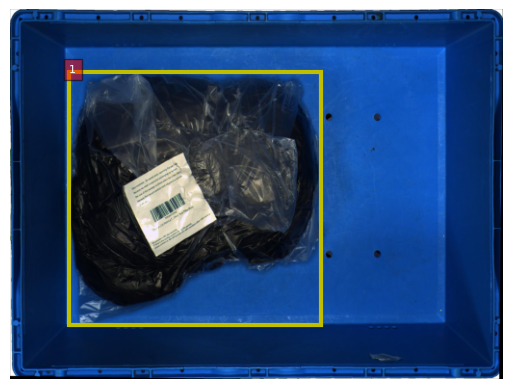

In [7]:
plot_bbox(img, {"bboxes": [b["bbox"] for b in boxes], "labels": [b["labels"] for b in boxes]})

In [3]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model

model_path = "/home/zanqi/LLaVA/llava/checkpoints/llava-v1.5-7b-task-lora"
model_base = "liuhaotian/llava-v1.5-7b"

tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=model_base,
    model_name=get_model_name_from_path(model_path)
)

/home/zanqi/miniconda3/envs/llava/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading LLaVA from base model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]/home/zanqi/miniconda3/envs/llava/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


Loading additional LLaVA weights...
Loading LoRA weights...
Merging LoRA weights...


/home/zanqi/miniconda3/envs/llava/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:325: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


Model is loaded...


/home/zanqi/miniconda3/envs/llava/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
model_path = "/home/zanqi/LLaVA/llava/checkpoints/llava-v1.5-7b-task-lora-merged"
model_base = "liuhaotian/llava-v1.5-7b"

get_model_name_from_path(model_path)

'llava-v1.5-7b-task-lora-merged'

In [15]:
model_path, model_base

('/home/zanqi/LLaVA/llava/checkpoints/llava-v1.5-7b-task-lora',
 'liuhaotian/llava-v1.5-7b')

In [28]:
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model

prompt = "Perform object detection on the given image. Resize the image to 1x1. What are the bounding boxes of the objects in the image? Output should be in  the format of a list of lists, where each list represents a bounding box: [[x_min, y_min, width, height], [x_min, y_min, width, height], ...] \n\nx_min and y_min are placeholder for the coordinate of the top left corner of an object bounding box, width and height are placeholder for the width and height of the bounding box. \n\nThe x_min, y_min, width and height of the bounding box should be positive decimal numbers between 0 and 1. \n\n \n\nFor example, if there are two objects in the image, the bounding boxes of the objects are [[0.13, 0.24, 0.37, 0.45], [0.50, 0.55, 0.23, 0.25]]."
image_file = "armbench/images/987.jpg"

model_base = "liuhaotian/llava-v1.5-7b"

args = type('Args', (), {
    "model_path": model_base,
    "model_base": None,
    "model_name": get_model_name_from_path(model_base),
    "query": prompt,
    "conv_mode": None,
    "image_file": image_file,
    "sep": ",",
    "temperature": 0.2,
    "top_p": None,
    "num_beams": 1,
    "max_new_tokens": 512
})()

eval_model(args)

/home/zanqi/miniconda3/envs/llava/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


[[0.13, 0.24, 0.37, 0.45], [0.5, 0.5, 0.23, 0.25]]


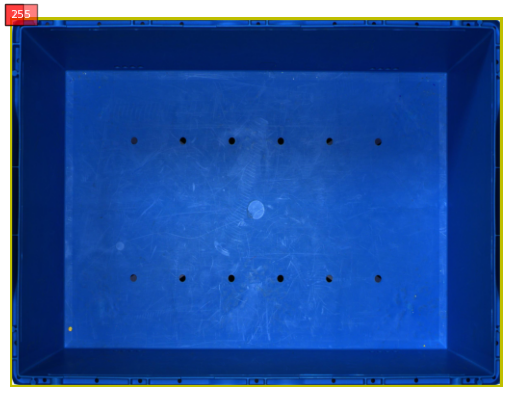

[0.         0.         0.99804688 0.99739583] 1
[0.         0.         0.99804688 0.99739583] 255


In [40]:
img, bboxes, cats =getImgAndBbox(99)
preds = [[0.1312, 0.2450, 0.3718, 0.4512], [0.5001, 0.5025, 0.2379, 0.2537]]

plot_bbox(img, bboxes, [], cats)
for i, b in enumerate(bboxes):
    print(b/np.array([512, 384, 512, 384]), cats[i])